In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import shutil
import matplotlib.pyplot as plt
%matplotlib inline 
import math
import tensorflow as tf
from IPython.display import Image, display
from sklearn.model_selection import train_test_split
from tensorflow.keras import Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.optimizers import SGD
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
train_folder = '/content/gdrive/MyDrive/Projects/flower_category_prediction/flower_dataset/train'
labels = os.listdir(train_folder)
num_classes = len(set(labels))
image_size = 224
batch_size=24
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                    horizontal_flip=True,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=(image_size, image_size),
    batch_size=24,
    class_mode='categorical'
    )

Found 1190 images belonging to 17 classes.


In [4]:
train_folder = '/content/gdrive/MyDrive/Projects/flower_category_prediction/flower_dataset/train'
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input,
                                    horizontal_flip=True,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    validation_split=0.2)# set validation split

train_generator = data_generator.flow_from_directory(
    train_folder,
    target_size=(image_size, image_size),
    batch_size=24,
    class_mode='categorical',
    subset='training'
    )
validation_generator = data_generator.flow_from_directory(
    train_folder,
    target_size=(image_size, image_size),
    batch_size=24,
    class_mode='categorical',
    subset='validation'
    )

Found 952 images belonging to 17 classes.
Found 238 images belonging to 17 classes.


In [5]:
test_folder = '/content/gdrive/MyDrive/Projects/flower_category_prediction/flower_dataset/test'
test_generator = data_generator.flow_from_directory(
    test_folder,
    target_size=(image_size, image_size),
    batch_size=24,
    class_mode='categorical'
    )

Found 170 images belonging to 17 classes.


In [6]:
# Create model
model = Sequential()
base_model = ResNet50(include_top=False, pooling='avg', weights='imagenet')
model.add(base_model)
model.add(Dense(256, activation='relu'))
model.add(Dropout(.5))
model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))
# Do not train first layer (ResNet) as it is already pre-trained
# base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 500

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers:
  layer.trainable =  False

# Compile model
sgd = SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Number of layers in the base model:  176
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 17)                4369      
Total params: 24,117,649
Trainable params: 529,425
Non-trainable params: 23,588,224
________________________________________________________________

In [7]:
NUM_EPOCHS = 100
EARLY_STOP_PATIENCE = 5
# Early stopping & checkpointing the best model in ../working dir & restoring that as our model for prediction


cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath = '/content/gdrive/MyDrive/Projects/flower_category_prediction/customized_best.hdf5',
                                  monitor = 'val_loss',
                                  save_best_only = True,
                                  mode = 'auto')

fit_history = model.fit_generator(
    train_generator,
    steps_per_epoch=10,
    validation_data=validation_generator,
    validation_steps=10,
    epochs=NUM_EPOCHS,
    callbacks=[cb_checkpointer, cb_early_stopper])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
10/10 [==============================] - 129s 13s/step - loss: 3.1760 - accuracy: 0.1185 - val_loss: 1.8098 - val_accuracy: 0.4664
Epoch 2/100
10/10 [==============================] - 89s 9s/step - loss: 1.7866 - accuracy: 0.4789 - val_loss: 1.2094 - val_accuracy: 0.6429
Epoch 3/100
10/10 [==============================] - 82s 9s/step - loss: 1.3140 - accuracy: 0.6085 - val_loss: 0.8474 - val_accuracy: 0.7563
Epoch 4/100
10/10 [==============================] - 83s 8s/step - loss: 1.0474 - accuracy: 0.7213 - val_loss: 0.7026 - val_accuracy: 0.8025
Epoch 5/100
10/10 [==============================] - 81s 8s/step - loss: 0.7943 - accuracy: 0.7865 - val_loss: 0.6344 - val_accuracy: 0.8025
Epoch 6/100
10/10 [==============================] - 81s 8s/step - loss: 0.6680 - accuracy: 0.8321 - val_loss: 0.5166 - val_accuracy: 0.8655
Epoch 7/100
10/10 [==============================] - 80s 8s/step - loss: 0.6385 - accuracy: 0.8761 - val_loss: 0.4688 - val_accuracy: 0.8824
Epoch 8/100

In [8]:
model.load_weights("/content/gdrive/MyDrive/Projects/flower_category_prediction/customized_best.hdf5")

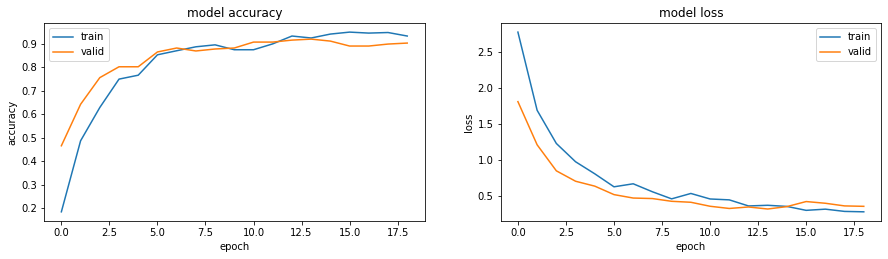

In [9]:
plt.figure(1, figsize = (15,8)) 
plt.subplot(221)  
plt.plot(fit_history.history['accuracy'])  
plt.plot(fit_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
plt.show()

In [10]:
train_steps = train_generator.n // batch_size
val_steps = validation_generator.n // batch_size
test_steps = test_generator.n // batch_size
# evaluate performance on train, val & test datasets
loss, acc = model.evaluate_generator(train_generator, steps=train_steps, verbose=1, workers=3)
print('Training data  -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model.evaluate_generator(validation_generator, steps=val_steps, verbose=1, workers=3)
print('Validation data -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model.evaluate_generator(test_generator, steps=test_steps, verbose=1, workers=3)
print('Testing data   -> loss: %.3f, acc: %.3f' % (loss, acc))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


39/39 [==============================] - 157s 4s/step - loss: 0.2261 - accuracy: 0.9679
Training data  -> loss: 0.226, acc: 0.968
9/9 [==============================] - 36s 4s/step - loss: 0.3610 - accuracy: 0.9074
Validation data -> loss: 0.361, acc: 0.907
7/7 [==============================] - 29s 4s/step - loss: 0.7223 - accuracy: 0.7857
Testing data   -> loss: 0.722, acc: 0.786


In [11]:
def predict_category(img_file):
    img = load_img(img_file, target_size=(image_size, image_size))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    classes = model.predict_classes(x)
    return classes

In [12]:
import os
classes_dict = train_generator.class_indices
test_img_path = '/content/gdrive/MyDrive/Projects/flower_category_prediction/flower_dataset/test'
test_img_dirs = os.listdir(test_img_path)

x_test, y_test, y_pred, test_img_paths = [], [], [], []
for dir in test_img_dirs:
    img_file_names = os.listdir(f'{test_img_path}/{dir}')
    for img_file in img_file_names:
        test_img_paths.append(f'{dir}/{img_file}')
        img_path = f'{test_img_path}/{dir}/{img_file}'
        # print(img_path)
        x_test.append(load_img(img_path))
        category = predict_category(img_path)
        # print(category)
        pred = list(classes_dict.keys())[list(classes_dict.values()).index(category[0])]
        y_pred.append(pred)
        y_test.append(dir)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


iris/image_0478.jpg
Actual : iris, Predicted : crocus


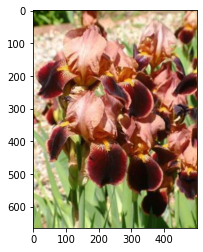

iris/image_0479.jpg
Actual : iris, Predicted : lilyvalley


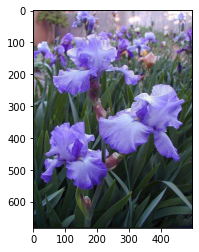

snowdrop/image_0154.jpg
Actual : snowdrop, Predicted : bluebell


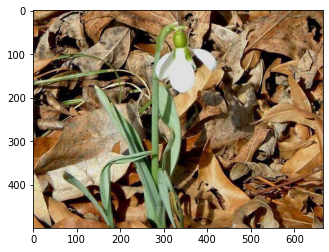

In [13]:
def plot_wrong_predictions(x_test, y_test, y_pred, test_img_paths, n = 1):
    count = 0
    for input, prediction, actual, test_img_path in zip (x_test, y_pred, y_test, test_img_paths):
        if count < n:
            if prediction != actual:
                print(test_img_path)
                print(f'Actual : {actual}, Predicted : {prediction}')
                plt.imshow(input)
                plt.show()
                count+=1
plot_wrong_predictions(x_test, y_test, y_pred, test_img_paths, n = 3)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


********************** Classification Report ***************************
              precision    recall  f1-score   support

    bluebell       0.17      0.70      0.28        10
   buttercup       0.00      0.00      0.00        10
   coltsfoot       1.00      0.20      0.33        10
     cowslip       0.00      0.00      0.00        10
      crocus       0.33      0.70      0.45        10
    daffodil       0.00      0.00      0.00        10
       daisy       0.60      0.90      0.72        10
   dandelion       1.00      0.90      0.95        10
  fritillary       1.00      0.70      0.82        10
        iris       0.73      0.80      0.76        10
  lilyvalley       0.53      1.00      0.69        10
       pansy       0.83      0.50      0.62        10
    snowdrop       0.45      0.90      0.60        10
   sunflower       1.00      0.40      0.57        10
   tigerlily       0.40      0.20      0.27        10
       tulip       0.00      0.00      0.00        10
  windfl

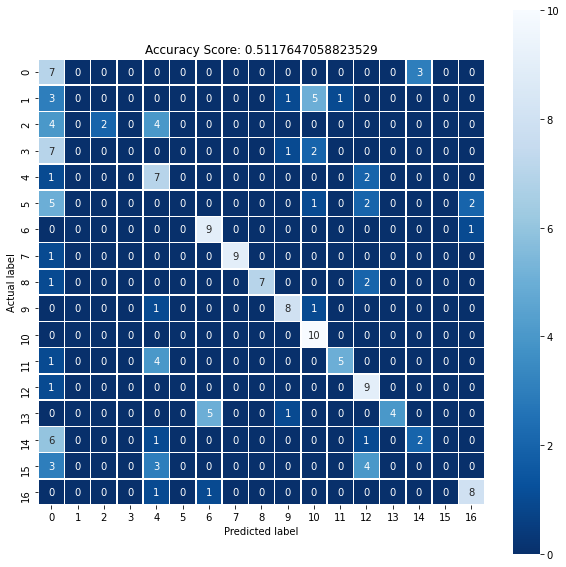

In [14]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
def evaluate_model(y_pred, y_test):
    martix = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    score = accuracy_score(y_test, y_pred)
    print('********************** Classification Report ***************************')
    print(report)

    plt.figure(figsize=(10,10))
    sns.heatmap(martix, annot=True, 
                linewidths=.5, square = True, cmap = 'Blues_r', fmt='g')

    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    all_sample_title = 'Accuracy Score: {0}'.format(score)
    plt.title(all_sample_title)
    plt.show()
    return martix, report

evaluation = evaluate_model(y_pred, y_test)